In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%%capture
!pip install tensorflow=='2.3.0' keras=='2.3.1' numpy=='1.18.5' \
  pandas_profiling=='2.7.1' sklearn

# <font color=#003091> Autoencoder en Keras - CIFAR10 </font>

Este notebook introduce los conceptos que se encuentran destrás de una red convolucional y muestra como entrenar una red de clasificación de imágenes con Keras.

In [3]:
from IPython.display import Image

import pandas as pd

from tensorflow import keras

import tensorflow as tf
import numpy as np
import os
import random

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rc("figure", figsize=(16, 9))

## Paso 1. Instalación
Vamos a utilizar Keras. Internamente Keras está ejecutando TensorFlow.

In [4]:
# Método generado para permitir que todas las ejecuciones terminen en una misma ejecución
def do_seeds(sn):
    os.environ['PYTHONHASHSEED']=str(sn)
    np.random.seed(sn)
    tf.random.set_seed(sn)
    random.seed(sn)

do_seeds(0)

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape) 

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [6]:
X_train.reshape((-1, 32*32*3))

array([[ 59,  62,  63, ..., 123,  92,  72],
       [154, 177, 187, ..., 143, 133, 144],
       [255, 255, 255, ...,  80,  86,  84],
       ...,
       [ 35, 178, 235, ...,  12,  31,  50],
       [189, 211, 240, ..., 195, 190, 171],
       [229, 229, 239, ..., 163, 163, 161]], dtype=uint8)

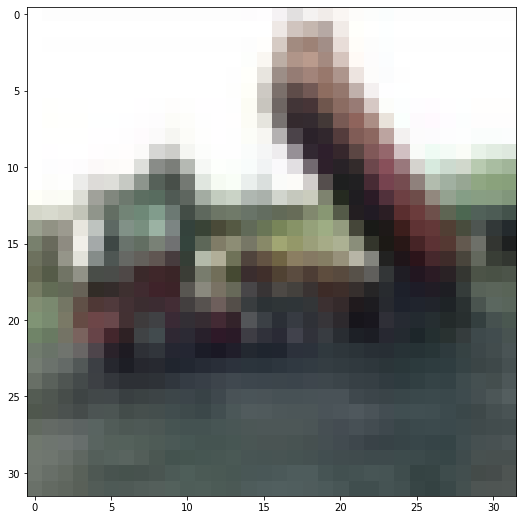

In [7]:
plt.imshow(X_train[2])

## Paso 2. Preparar los datos
Como se ha comentado previamente, se disponen de un conjunto de imágenes para predecir. Para poder introducirlas a una red neuronal necesitamos de un vector plano de valores de entrada. Además, debido a que una red neuronal necesita de valores entre [0,1], la imagen se necesita normalizar (la imagen tiene pixeles entre los rangos [0,255]) para facilitar el entrenamiento.

In [8]:
# Normalizar las imágenes
X_train = X_train / 255 
X_test = X_test / 255

# Transformar la imagen en un vector
X_train = X_train.reshape((-1, 32*32*3))
X_test = X_test.reshape((-1, 32*32*3))

print(X_train.shape) 
print(X_test.shape)  

(50000, 3072)
(10000, 3072)


## Construcción del primer autoencoder

In [9]:
input_img = 32*32*3

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

model_autoc = Sequential()

# Encoder
model_autoc.add(Dense(1200, activation="relu", input_shape=(input_img,)))
model_autoc.add(Dense(350, activation="relu", name="encoded"))
# Decoder
model_autoc.add(Dense(1200, activation="relu"))
model_autoc.add(Dense(input_img, activation='sigmoid'))

model_autoc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1200)              3687600   
_________________________________________________________________
encoded (Dense)              (None, 350)               420350    
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              421200    
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              3689472   
Total params: 8,218,622
Trainable params: 8,218,622
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_autoc.compile(
  optimizer='adam',
  loss='mse',
  metrics=[tf.keras.metrics.MeanAbsolutePercentageError()], 
)

In [12]:
history_model_autoc = model_autoc.fit(
  X_train, 
  X_train, 
  epochs=7,
  batch_size=128,
  validation_split=0.2 #Permite dividir el conjunto de train en train/eval
)

Epoch 1/7
313/313 [==============================] - 2s 7ms/step - loss: 0.0295 - mean_absolute_percentage_error: 495907.1875 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 315663.8750
Epoch 2/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0150 - mean_absolute_percentage_error: 300640.5312 - val_loss: 0.0131 - val_mean_absolute_percentage_error: 309410.2812
Epoch 3/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0124 - mean_absolute_percentage_error: 266224.3438 - val_loss: 0.0113 - val_mean_absolute_percentage_error: 270560.3125
Epoch 4/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0111 - mean_absolute_percentage_error: 243992.9531 - val_loss: 0.0109 - val_mean_absolute_percentage_error: 263779.5000
Epoch 5/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0103 - mean_absolute_percentage_error: 231882.9531 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 217203.8906
Epoch 6/7
313/313 [======

Mediante esta función se puede escoger una función de interés

In [13]:
print(model_autoc.get_layer("encoded").output)

Tensor("encoded/Relu:0", shape=(None, 350), dtype=float32)


In [14]:
from tensorflow.keras.models import Model

# Sintaxis - Model(input layer, layer de interés - encoded layer)
model_autoc_encoded = Model(model_autoc.input, model_autoc.get_layer('encoded').output)
model_autoc_encoded.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 1200)              3687600   
_________________________________________________________________
encoded (Dense)              (None, 350)               420350    
Total params: 4,107,950
Trainable params: 4,107,950
Non-trainable params: 0
_________________________________________________________________


In [15]:
X_test_encoded = model_autoc_encoded.predict(X_test)
X_test_decoded = model_autoc.predict(X_test)

X_test.shape, X_test_encoded.shape, X_test_decoded.shape

((10000, 3072), (10000, 350), (10000, 3072))

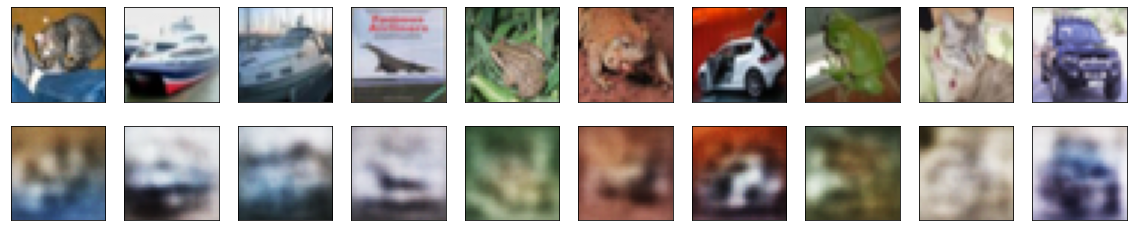

In [16]:
def plot_images(n, test, model_decoded=None, test_images=None):
    if model_decoded is not None:
        test_decoded = model_decoded.predict(test)
    else:
        test_decoded = test_images
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(test_decoded[i].reshape(32, 32, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
plot_images(10, X_test, model_autoc)

### Pregunta
- ¿Por qué se ha perdido tanta información en la reconstrucción?
- ¿Cómo se podría evitar?

## Introducción a Denoising Autoencoder

Método para calcular el ruido - Ruido con distribución normal (0 de media y 1 de desviación típica)

In [17]:
pd.DataFrame(np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.001152,0.014338,0.000456,-0.006570,0.003491,-0.005960,-0.000947,-0.004596,-0.006045,-0.003695,0.006501,0.003741,0.000598,0.000259,-0.008333,0.001118,-0.000383,0.006053,0.001030,0.000368,-0.007277,-0.000890,-0.009976,-0.000389,0.007756,0.004602,0.004614,0.004434,0.002402,0.003389,0.001685,-0.006489,-0.001067,-0.007652,-0.005910,0.004800,0.001948,-0.004737,-0.001644,-0.007580,...,0.009180,-0.003919,-0.001939,-0.001033,-0.005932,-0.000925,-0.005510,-0.001426,-0.001047,-0.003971,0.001791,-0.006915,-0.004964,-0.001328,0.001980,-0.005063,-0.003059,0.000498,-0.003594,-0.004539,0.001329,0.004563,0.000126,-0.000727,-0.000063,0.001233,0.007998,-0.003449,0.008150,-0.000461,0.000434,0.003541,0.000338,0.002511,0.002367,-0.002387,-0.004692,-0.002842,-0.002355,-0.005169
std,0.998966,0.999692,1.001985,0.997094,1.001619,1.001464,1.000271,1.005578,1.002757,1.002422,0.999098,1.000214,0.995942,1.000444,0.995508,1.003355,1.002782,0.999633,1.000012,0.998128,0.998017,1.004169,1.001719,1.004379,0.999573,0.996645,0.995292,1.006823,0.996073,0.996645,1.002504,1.002913,0.995037,0.992678,1.001101,0.999267,0.996233,0.994957,0.995133,0.998398,...,1.007232,1.005666,1.004599,1.002791,0.999712,1.004610,1.003698,0.994994,1.000540,0.999996,0.997328,1.001729,1.000881,0.992441,0.999312,0.998237,1.000021,1.002478,1.000879,0.996416,1.002215,0.997869,1.000305,1.001940,1.002007,0.993787,1.005593,1.002615,1.000781,0.990838,0.999664,1.002489,1.001106,0.997247,0.996627,0.998949,0.997790,0.999752,1.001362,1.000692
min,-4.137748,-4.220508,-4.947710,-4.231400,-4.337821,-4.298086,-4.799704,-4.283378,-4.028977,-3.943723,-4.368941,-3.982682,-3.750222,-4.184335,-4.404821,-4.098315,-4.031561,-4.163253,-4.397406,-4.852885,-3.977234,-4.002163,-3.931857,-4.150204,-4.385045,-4.272031,-4.225108,-4.598004,-4.271564,-3.845172,-5.017580,-4.450048,-3.868360,-4.029336,-3.924404,-3.620921,-4.024775,-3.798435,-4.156286,-4.184900,...,-4.523550,-4.213513,-4.328016,-4.387279,-4.111952,-3.958845,-4.555870,-4.269941,-4.097693,-4.846426,-3.996963,-4.084008,-4.301248,-3.981661,-3.804529,-4.167535,-4.061955,-4.837918,-4.223192,-4.298488,-3.975266,-3.964090,-4.095286,-3.923466,-4.213993,-4.349012,-4.306303,-4.732828,-3.968160,-4.334049,-4.109712,-4.336084,-4.188356,-4.348408,-4.740759,-4.001395,-4.175534,-4.101354,-4.017142,-3.991368
25%,-0.670032,-0.655483,-0.678667,-0.681592,-0.670984,-0.682680,-0.675708,-0.679844,-0.682580,-0.680209,-0.668649,-0.668445,-0.670531,-0.674024,-0.681832,-0.679857,-0.671792,-0.668846,-0.676641,-0.669764,-0.683571,-0.674815,-0.687760,-0.676398,-0.664453,-0.672130,-0.666006,-0.677285,-0.665967,-0.669902,-0.672803,-0.679416,-0

Se introducir un intervalor máximo y mímino a las predicciones

In [18]:
np.clip([-0.5, 0.5, 1.5], 0., 1.)

array([0. , 0.5, 1. ])

In [19]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [20]:
# Transformar el vector en imagen de nuevo
X_train_noisy_image = X_train_noisy.reshape((-1, 32, 32, 3))
X_test_noisy_image = X_test_noisy.reshape((-1, 32, 32, 3))

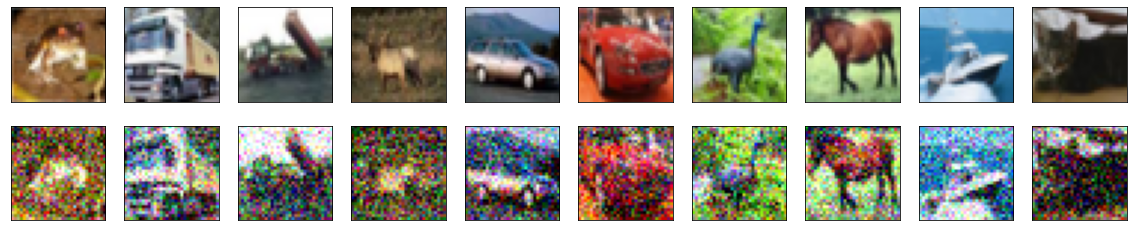

In [21]:
plot_images(10, X_train, None, X_train_noisy_image)

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

model_autoc_noisy = Sequential()
# Encoder
model_autoc_noisy.add(Dense(1200, activation="relu", input_shape=(input_img,)))
model_autoc_noisy.add(Dense(350, activation="relu", name="encoded2"))
# Decoder
model_autoc_noisy.add(Dense(1200, activation="relu"))
model_autoc_noisy.add(Dense(input_img, activation='sigmoid'))

model_autoc_noisy.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1200)              3687600   
_________________________________________________________________
encoded2 (Dense)             (None, 350)               420350    
_________________________________________________________________
dense_4 (Dense)              (None, 1200)              421200    
_________________________________________________________________
dense_5 (Dense)              (None, 3072)              3689472   
Total params: 8,218,622
Trainable params: 8,218,622
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_autoc_noisy.compile(
  optimizer='adam',
  loss='mse',
  metrics=[tf.keras.metrics.MeanAbsolutePercentageError()], 
)

In [24]:
history_model_autoc_noisy = model_autoc_noisy.fit(
  X_train_noisy, 
  X_train, 
  epochs=7,
  batch_size=128,
  validation_split=0.2 #Permite dividir el conjunto de train en train/eval
)

Epoch 1/7
313/313 [==============================] - 2s 7ms/step - loss: 0.0310 - mean_absolute_percentage_error: 555424.2500 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 394131.9375
Epoch 2/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0163 - mean_absolute_percentage_error: 345708.3438 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 334135.5938
Epoch 3/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0139 - mean_absolute_percentage_error: 307101.8125 - val_loss: 0.0133 - val_mean_absolute_percentage_error: 290993.4062
Epoch 4/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0127 - mean_absolute_percentage_error: 286359.0312 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 347503.4375
Epoch 5/7
313/313 [==============================] - 2s 6ms/step - loss: 0.0121 - mean_absolute_percentage_error: 278525.9062 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 274294.2812
Epoch 6/7
313/313 [======

In [25]:
model_autoc_noisy_encoded = Model(model_autoc_noisy.input, model_autoc_noisy.get_layer('encoded2').output)
model_autoc_noisy_encoded.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3_input (InputLayer)   [(None, 3072)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1200)              3687600   
_________________________________________________________________
encoded2 (Dense)             (None, 350)               420350    
Total params: 4,107,950
Trainable params: 4,107,950
Non-trainable params: 0
_________________________________________________________________


In [26]:
X_test_encoded = model_autoc_noisy_encoded.predict(X_test)
X_test_decoded = model_autoc_noisy.predict(X_test)

X_test.shape, X_test_encoded.shape, X_test_decoded.shape

((10000, 3072), (10000, 350), (10000, 3072))

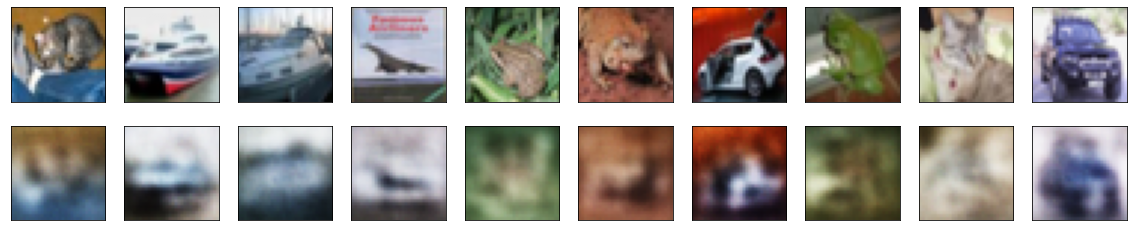

In [28]:
plot_images(10, X_test, model_autoc_noisy)

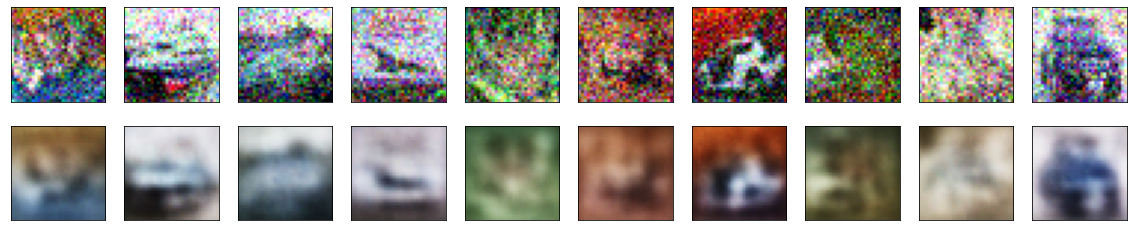

In [29]:
plot_images(10, X_test_noisy, model_autoc_noisy)

### Pregunta
- ¿Por qué el modelo no ha sido capaz de eliminar satisfactoriamente el ruido?
- ¿Cómo se podría mejorar?

### References

- https://keras.io/examples/generative/vae/
- https://blog.keras.io/building-autoencoders-in-keras.html